# Problem statement, Data dictionary

Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.

- CELLID_elevation	Continuous	
Digital elevation of the terrain surface in meter

- CELLID_slope	Continuous	
Angle of the slope inclination in degree

- CELLID_aspect	Continuous	
Exposition of the slope in degree
(direction of the slope?) -> dummied to 8 NSEW

- CELLID_placurv	Continuous	
Planform curvature, curvature perpendicular to the direction of the maximum slope

- CELLID_procurv	Continuous	
Profile curvature, curvature parallel to the slope, indicating the direction of maximum slope

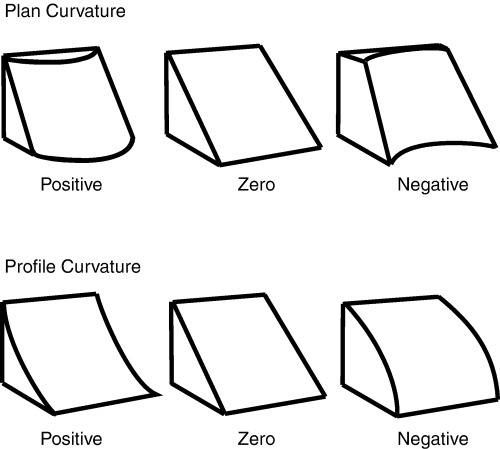


- CELLID_lsfactor	Continuous	
Length-slope factor that accounts for the effects of topography on erosion

- CELLID_twi	Continuous	
Topographic wetness index, an index to quantify the topographic control on hydrological process

- CELLID_geology	Categorical	Lithology of the surface material
1: Weathered Cretaceous granitic rocks
2: Weathered Jurassic granite rocks
3: Weathered Jurassic tuff and lava
4: Weathered Cretaceous tuff and lava
5: Quaternary deposits
6: Fill
7: Weathered Jurassic sandstone, siltstone and mudstone

- CELLID_sdoif	Continuous	
Step duration orographic intensification factor: an index to quantify the amplification of orography on rainfall


# 0. Import

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# all columns, limit 200 rows
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 200)

# round up DISPLAY 4 decimal
pd.options.display.float_format = "{:,.4f}".format

import time

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.feature_selection import RFE



from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# !conda install -c conda-forge py-xgboost 
# !pip install xgboost
import xgboost as xgb

from sklearn.metrics import ( 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    plot_confusion_matrix, 
    classification_report, 
    precision_recall_curve,
    make_scorer,
 
) 

# 1. Data preprocessing

In [8]:
df = pd.read_csv('landslide_engineered_features.csv')
df.head()

,Label,aspect_NSEW,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center
0,0,SE,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,++-,0.0214,+--,0.0668,19.2870,3.1545,3.4665,3,3,1.2817
1,1,S,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,+++,-0.0193,---,0.0055,16.6390,4.3839,4.6605,3,3,1.3596
2,0,W,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,+++,-0.0274,+++,0.0026,28.8700,4.1693,4.2278,2,2,1.3651
3,0,S,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,+++,-0.0229,+-+,0.0146,8.2114,4.2599,3.7378,2,2,1.1008
4,0,SE,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,---,0.0181,---,0.0205,15.8179,4.4302,4.5421,2,5,1.2842


In [9]:
# Dummy
to_dummies = ['aspect_NSEW']
aspect_NSEW_dummies = pd.get_dummies(df[to_dummies], drop_first=True)
aspect_NSEW_dummies.columns = [x.replace('_NSEW','') for x in aspect_NSEW_dummies.columns]
df = pd.concat([df, aspect_NSEW_dummies], axis=1)

df.drop(columns='aspect_NSEW', inplace=True)

In [10]:
# convert to woe
from custom_functions import WOE

temp = pd.read_csv('df\Train.csv')
placurv_cols = temp.columns[1+25*3:26+25*3].tolist()
procurv_cols = temp.columns[1+25*4:26+25*4].tolist()

df = pd.concat([df, temp[placurv_cols]], axis=1)
df.placurv_signs_8 = df.placurv_signs_8.map(WOE.convert_woe_cat('placurv_signs_8', df)['WOE'])

df = pd.concat([df, temp[procurv_cols]], axis=1)
df.procurv_signs_8 = df.procurv_signs_8.map(WOE.convert_woe_cat('procurv_signs_8', df)['WOE'])

df.drop(columns=placurv_cols+procurv_cols, inplace=True)

Information value: 0.13
Information value: 0.11


In [11]:
df.head()

,Label,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center,aspect_N,aspect_NE,aspect_NW,aspect_S,aspect_SE,aspect_SW,aspect_W
0,0,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,0.1635,0.0214,0.3706,0.0668,19.2870,3.1545,3.4665,3,3,1.2817,0,0,0,0,1,0,0
1,1,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,-0.4845,-0.0193,0.1837,0.0055,16.6390,4.3839,4.6605,3,3,1.3596,0,0,0,1,0,0,0
2,0,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,-0.4845,-0.0274,-0.4567,0.0026,28.8700,4.1693,4.2278,2,2,1.3651,0,0,0,0,0,0,1
3,0,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,-0.4845,-0.0229,-0.3943,0.0146,8.2114,4.2599,3.7378,2,2,1.1008,0,0,0,1,0,0,0
4,0,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,0.1881,0.0181,0.1837,0.0205,15.8179,4.4302,4.5421,2,5,1.2842,0,0,0,0,1,0,0


## Train/test, scale

In [12]:
X = df.drop(columns='Label')
Y = df.Label

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=14)

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), index = X_test.index, columns = X_test.columns)

**Class weights**

In [17]:
y_train.value_counts(normalize=True)

0   0.7500
1   0.2500
Name: Label, dtype: float64

In [18]:
class_weights = {0: .25, 1: .75}

# 2. Random Forest

## Custom functions

In [13]:
from custom_functions import classification_functions as clf

In [14]:
def tree_model_perf(model, model_name):
    start = time.time()
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)
    yhat_proba = model.predict_proba(X_test)[::,1]
    auc_score = metrics.roc_auc_score( y_test, yhat_proba )
    
    time_complete = time.time() - start
    
    print(f'{model_name}:  AUC = {auc_score:.3f}, Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    
    
    
    clf.cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

## Base model

RF_base:  AUC = 0.881, Time: 1.21
Train
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      7333
           1       0.67      0.91      0.77      2444

    accuracy                           0.87      9777
   macro avg       0.82      0.88      0.84      9777
weighted avg       0.89      0.87      0.87      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       815
           1       0.60      0.78      0.68       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.84      0.82      0.82      1087



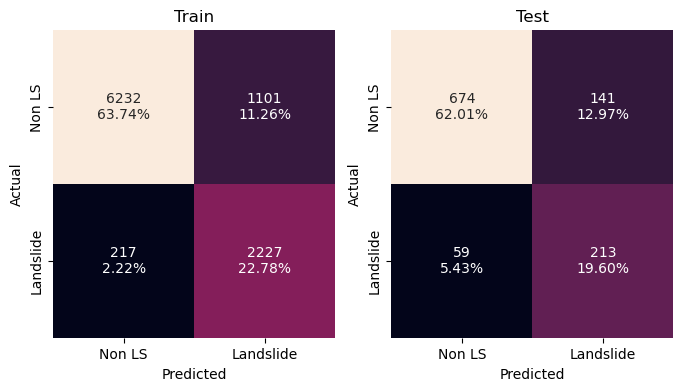

******************************************************************************************


In [19]:
RF_base = RandomForestClassifier(max_depth=10,min_samples_split=10, min_samples_leaf=3, class_weight= class_weights,  random_state = 14)
tree_model_perf(RF_base, 'RF_base')

## Hyper parameter tuning 2 (class weight)

### 1

In [20]:
%%time
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 1.31 s
Wall time: 8.07 s


{'max_depth': 10, 'n_estimators': 100}

RF_tuned1:  AUC = 0.883, Time: 1.22
Train
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7333
           1       0.69      0.95      0.80      2444

    accuracy                           0.88      9777
   macro avg       0.83      0.90      0.86      9777
weighted avg       0.91      0.88      0.89      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       815
           1       0.61      0.79      0.69       272

    accuracy                           0.82      1087
   macro avg       0.77      0.81      0.78      1087
weighted avg       0.84      0.82      0.83      1087



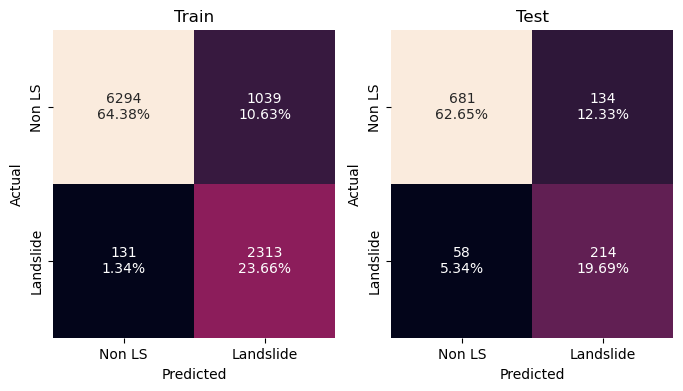

******************************************************************************************


In [21]:
RF_tuned1 = grid_search.best_estimator_
tree_model_perf(RF_tuned1, 'RF_tuned1')

### 2

In [22]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    # 'n_estimators': [50, 100],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 1.14 s
Wall time: 5.46 s


{'max_depth': 9}

RF_tuned2:  AUC = 0.881, Time: 1.18
Train
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7333
           1       0.65      0.92      0.76      2444

    accuracy                           0.85      9777
   macro avg       0.81      0.88      0.83      9777
weighted avg       0.89      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.77      0.81      0.78      1087
weighted avg       0.85      0.82      0.83      1087



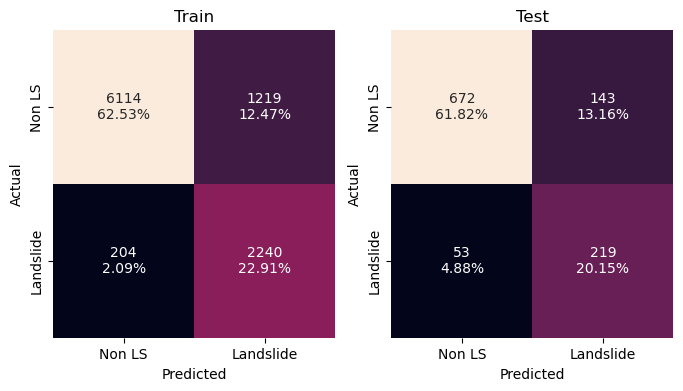

******************************************************************************************


In [23]:
RF_tuned2 = grid_search.best_estimator_
tree_model_perf(RF_tuned2, 'RF_tuned2')

### 3

We now have a quite comparable performance between train and test set.

Adjusting min samples in leaf and split

In [24]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    # 'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 2.84 s
Wall time: 36 s


{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}

RF_tuned3:  AUC = 0.881, Time: 1.14
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



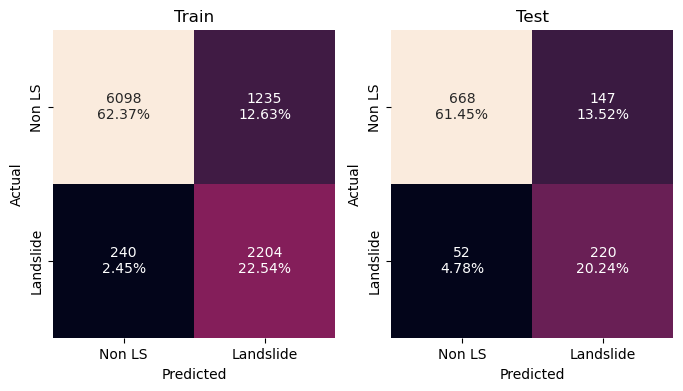

******************************************************************************************


In [25]:
RF_tuned3 = grid_search.best_estimator_
tree_model_perf(RF_tuned3, 'RF_tuned3')

### 4

Increase ms split parameter

In [26]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8, 9],
    # 'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 3.25 s
Wall time: 47.3 s


{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}

RF_tuned4:  AUC = 0.881, Time: 1.13
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



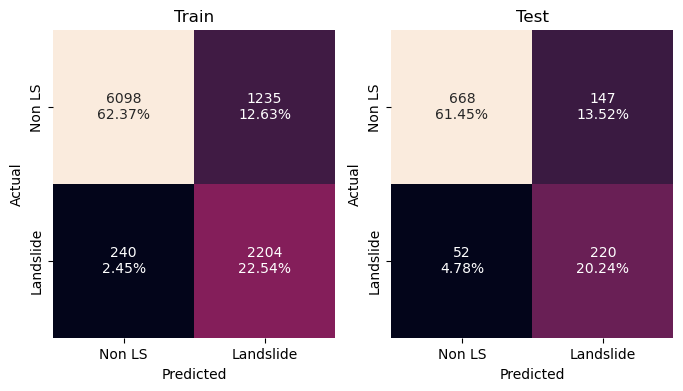

******************************************************************************************


In [27]:
RF_tuned4 = grid_search.best_estimator_
tree_model_perf(RF_tuned4, 'RF_tuned4')

### 5

No change. Add n_estimators

In [28]:
%%time
param_grid = {
    'max_depth': [8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 4.39 s
Wall time: 1min 25s


{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 80}

RF_tuned5:  AUC = 0.880, Time: 0.95
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



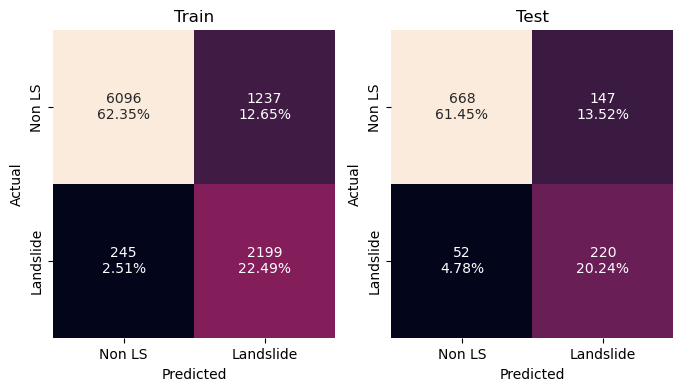

******************************************************************************************


In [29]:
RF_tuned5 = grid_search.best_estimator_
tree_model_perf(RF_tuned5, 'RF_tuned5')

### 6

Lower n_estimator further

In [30]:
%%time
param_grid = {
    'max_depth': [8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [50, 80, 100, 120],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 4.55 s
Wall time: 56.4 s


{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 80}

RF_tuned6:  AUC = 0.880, Time: 0.93
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



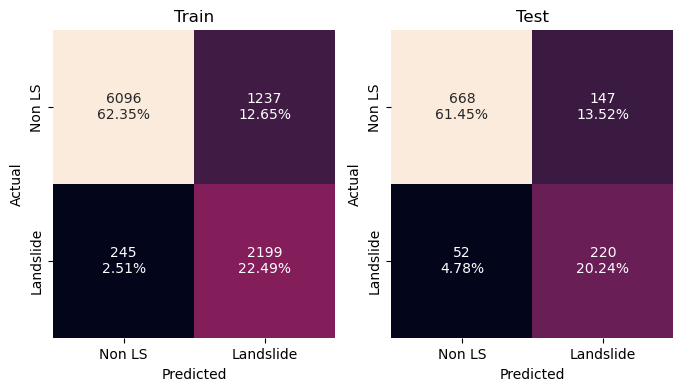

******************************************************************************************


In [31]:
RF_tuned6 = grid_search.best_estimator_
tree_model_perf(RF_tuned6, 'RF_tuned6')

### 7

RF_tuned7:  AUC = 0.881, Time: 0.90
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.89      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.86      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       815
           1       0.61      0.79      0.69       272

    accuracy                           0.82      1087
   macro avg       0.77      0.81      0.78      1087
weighted avg       0.84      0.82      0.83      1087



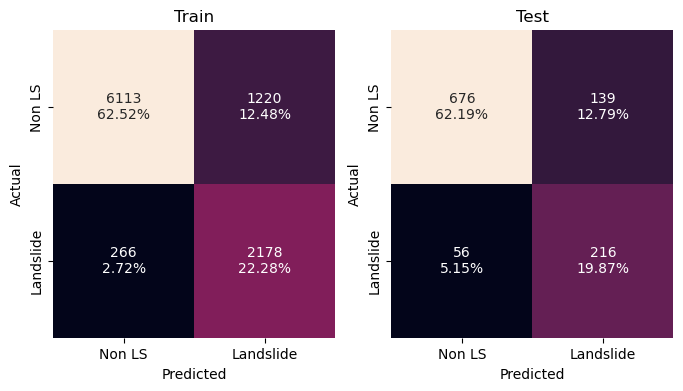

******************************************************************************************


In [45]:
RF_tuned7 = RandomForestClassifier(
    class_weight= class_weights, 
    random_state=14,
    bootstrap=True,
    oob_score=True,
    max_samples=0.8,
    max_depth= 9,
    min_samples_leaf= 2,
    min_samples_split= 7,
    n_estimators= 80,
)

tree_model_perf(RF_tuned7, 'RF_tuned7')

## Comparing AUC

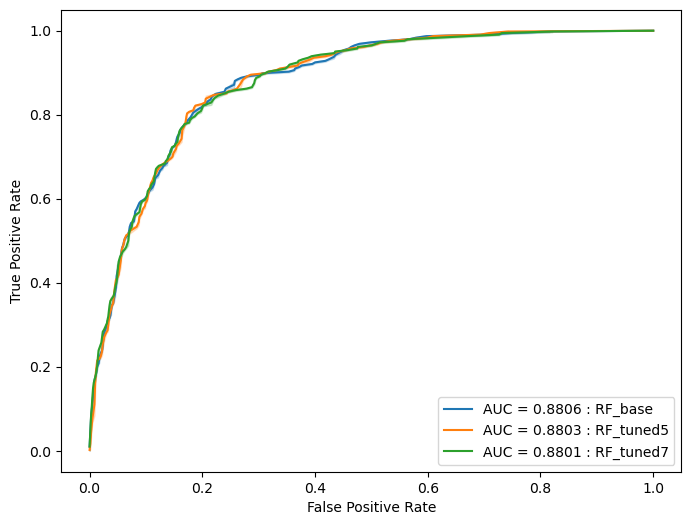

In [53]:
plt.figure(figsize=(8,6))

for model, model_name in [
    (RF_base, 'RF_base'),
    (RF_tuned5, 'RF_tuned5'),
    (RF_tuned7, 'RF_tuned7')
]:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score(y_test,  yhat_proba)
    space = ' ' * (20 - len(model_name))
    sns.lineplot(x=fpr,y=tpr, label=f'AUC = {auc_score:0.4f} : {model_name}')
    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()    

## Kfold cross validation

### ROC_AUC

In [73]:
RF_base_CV = cross_validate(RF_base, X, Y, cv=5, scoring='roc_auc')
pd.DataFrame(RF_base_CV).mean()

fit_time     0.9258
score_time   0.0312
test_score   0.8762
dtype: float64

In [74]:
RF_tuned5_CV = cross_validate(RF_tuned5, X, Y, cv=5, scoring='roc_auc')
pd.DataFrame(RF_tuned5_CV).mean()

fit_time     0.7162
score_time   0.0250
test_score   0.8738
dtype: float64

In [75]:
RF_tuned7_CV = cross_validate(RF_tuned7, X, Y, cv=5, scoring='roc_auc')
pd.DataFrame(RF_tuned7_CV).mean()

fit_time     0.7114
score_time   0.0248
test_score   0.8726
dtype: float64